# Part 1 - Trending & Summary Slides

## A. Raw Data

### A1. Import Packages

In [47]:
import pandas as pd # dataframes
import calendar # for adding date names
import numpy as np # math
from scipy.stats import f_oneway, ttest_rel # statistics
from Ian import Benchmarks # QualiTiers
import seaborn as sns # visuals
import PandasToPowerPoint as p2p # make PowerPoints
from pptx.enum.dml import MSO_THEME_COLOR # color text based on PPT theme
from pptx.enum.text import PP_ALIGN # for aligning text
from pptx.enum.text import MSO_ANCHOR # for anchoring text in table
from pptx.util import Inches, Pt # add Inches for sizing PPT elements
from matplotlib import style # formatting visual
import matplotlib.pyplot as plt # more visuals (histogram)
import matplotlib as mpl

### A2. User Input & Import Data

In [2]:
# LUKE_MO (St. Lukes)
client = "LUKE_MO"
old_year_month = "January 2019"
new_year_month = "January 2020"
# Provider Performance filepath
all_years = rf"C:\Users\ao054198\Downloads\STLUKES_non_scorecard_limited_performance_data_2020-01-01.csv"
# read data as dataframe
df = pd.read_csv(all_years,encoding = "ISO-8859-1")
# enter registries you want; or replace with 'all'
registries_list = ['Comprehensive Adult Wellness','Diabetes Mellitus','Hypertension']
measures_list = ['Breast Cancer Screening','Body Mass Index',
                 'Colorectal Cancer Screening','Depression Screening',
                 'Fall Risk Screening','Annual Eye Exam',
                 'Hba1c Poorly Controlled Hba1c Gt 9','Hba1c Screening',
                 'Medical Attention To Nephropathy','Statin Therapy Diabetic Group',
                'Bp Less Than 140 90']
# QualiTiers filepath
path = rf"C:\Users\ao054198\Downloads\LUKE_MO_non_scorecard_limited_benchmark_data_2019Q4 (2).csv"
# Org Hierarchy filepath
org_path = rf"\\mustang\workops_pub\Pop Health\DataWorks\Data Insights\Client Files\LUKE_MO\3. Data\LUKE_MO Org Hierarchy Filtered.csv"

### A3. Clean Data

In [3]:
# lowercase columns
df.columns = df.columns.str.lower()

In [4]:
# formate date column
df.loc[:, 'date'] = pd.to_datetime(df.date.copy()).dt.date.astype(str)

In [5]:
# rename columns (for quicker typing)
df.rename(columns = {
    'personnel' : 'prsnl',
    'personnel_id' : 'prsnl'
}, inplace = True)

In [6]:
# make numerator & denominator integers
df.numerator = df.numerator.astype(int)
df.denominator = df.denominator.astype(int)

In [7]:
# replace client NaN with first client listed (should all be the same)
df.client = client

### A4. Filter Data

In [8]:
# filter by dates
df = df.loc[df.date.isin(['2019-01-01','2020-01-01'])]

In [9]:
# keep only specified registries
df = df.loc[df['registry'].isin(registries_list)]

In [10]:
# set aside date variables for later
dt_min = df.date.min()
dt_max = df.date.max()
# extract max date and min date names
dt_max_name = dt_max.replace(dt_max,calendar.month_name[int(dt_max[5:7])]+' '+dt_max[0:4])
dt_min_name = dt_min.replace(dt_min,calendar.month_name[int(dt_min[5:7])]+' '+dt_min[0:4])

### A5. Add Columns
#### Create 'All' Measure, 'All' Registry

##### Measure

In [11]:
# for each date, registry, prsnl, sum num & den
# sum num/den for each registry, date, prsnl
mall = df.groupby([
    'date',
    'registry',
    'prsnl'
]).agg({
    'numerator' : 'sum',
    'denominator' : 'sum'
})

# call it the 'All' measure
mall.insert(mall.shape[1], 'measure', 'All')

##### Registry

In [12]:
# find total numerator/denominator for each provider across date
rall = mall.sum(level = [
    'date',
    'prsnl'
])

# create 'All' registry and measure
rall.loc[:, 'registry'], rall.loc[:, 'measure'] = 'All', 'All'

##### Merge

In [13]:
# reset mall, rall indices and concatenate them together
rmall = pd.concat([
    mall.reset_index(),
    rall.reset_index()
],sort=False)

In [14]:
# merge rmall with df to have access to 'All' registry and measure
df = df.merge(rmall, how = 'outer', on = rmall.columns.tolist())

In [15]:
# create measure met column
df["met"] = df["numerator"] / df["denominator"]

In [16]:
# make the "data" dataframe from df
data = df

## B. Current State

### B1. Add Stats Table

### 1.1 Make 'Bible' Function

In [17]:
# requires one row per 
def bible(x, col):
#     make dictionary of functions
    d = {}
#     count
    d['count'] = x[col].count()
#     standard deviation
    d['std'] = x[col].std()
#     median
    d['median'] = x[col].median()
#     mean
    d['mean'] = x[col].mean()
#     variance
    d['var'] = x[col].var()
#     lower confidence interval
    d['lci'] = x[col].mean() - 1.96 * x[col].std() / np.sqrt(len(x))
#     upper confidence interval
    d['uci'] = x[col].mean() + 1.96 * x[col].std() / np.sqrt(len(x))
#     score
    d['score'] = x[col].std() + (1 + x[col].mean()) * 100
#     sum of numerator
    d['numerator_sum'] = x.numerator.sum()
#     sum of denominator
    d['denominator_sum'] = x.denominator.sum()
    
    return pd.Series(d, index = [
        'mean',
        'std',
        'lci',
        'uci',
        'count',
        'median',
        'var',
        'score',
        'numerator_sum',
        'denominator_sum'
    ])

In [18]:
# apply the bible and call it the stats table
stats_table = df.groupby([
    'date',
    'registry',
    'measure'
]).apply(bible, 'met')

In [19]:
# add total_measure_met
stats_table['total_measure_met'] = stats_table.numerator_sum / stats_table.denominator_sum

In [20]:
# specify column order
reorderlist = ['mean', 'std', 'lci', 'uci', 'count', 'median', 'var', 'score', 'numerator_sum', 'denominator_sum', 'total_measure_met']

# unstack date and sort index (for viewing only)
stat_unstack = stats_table.unstack('date').swaplevel(1, 0, axis = 1).sort_index(axis = 1).reindex(columns=reorderlist,level=1)

In [21]:
# find difference in means, find difference in total_measure_mets
stat_unstack['change_of_means'], stat_unstack['change_total_measure_met'] = stat_unstack[dt_max]['mean'] - stat_unstack[dt_min]['mean'], stat_unstack[dt_max]['total_measure_met'] - stat_unstack[dt_min]['total_measure_met']
stat_unstack['change_of_std'], stat_unstack['change_total_measure_met'] = stat_unstack[dt_max]['std'] - stat_unstack[dt_min]['std'], stat_unstack[dt_max]['total_measure_met'] - stat_unstack[dt_min]['total_measure_met']

### B2. Make Current State

In [22]:
# Current State Slide per Registry
cs = stat_unstack[dt_max]
# Drop rows with NAs
cs = cs.dropna(how='any',axis=0)
# format
cs["conf_int"] = '('+((cs['lci'])*100).round(1).astype(str) + '%' + ' - ' + ((cs['uci'])*100).round(1).astype(str) + '%' +')'
cs['mean'] = ((cs['mean'])*100).round(1).astype(str) + '%'
cs['std'] = ((cs['std'])*100).round(1).astype(str) + '%'
cs['count'] = cs['count'].astype(int)
# drop unneeded columns
cs = cs[[
    "count",
    "mean",
    "conf_int",
    "std"
]]
# rename columns
cs.rename(columns={"count":"Providers","mean":"Measure Met","conf_int":"95% Confidence Interval","std":"Standard Deviation"},inplace=True)
cs = cs.reset_index()
cs.columns = cs.columns.str.title()
current_state = cs

## C. Trending

### C1. Intersect Personnel
Make a table where only prsnl who appear in both old and new dates are kept

In [23]:
# drop registry, measure, prsnl without both dates
intersect = df.groupby([
    'registry',
    'measure',
    'prsnl',
    'date'
]).agg({
    'date' : 'max'
}).unstack('date').dropna().stack('date').index.to_frame().reset_index(drop = True)

# merge df with intersection
df_i = df.merge(intersect, how = 'inner', on = [
    'registry',
    'measure',
    'prsnl',
    'date'
])

In [24]:
# apply the bible and call it stats table intersection
stats_table_i = df_i.groupby([
    'date',
    'registry',
    'measure'
]).apply(bible, 'met')

# add total_measure_met
stats_table_i['total_measure_met'] = stats_table_i.numerator_sum / stats_table_i.denominator_sum

# unstack date and sort index (for viewing only)
stat_unstack_i = stats_table_i.unstack('date').swaplevel(1, 0, axis = 1).sort_index(axis = 1)

# subtract means, subtract total_measure_mets
#stat_unstack_i['change_of_means'], stat_unstack_i['change_total_measure_met'] = stat_unstack_i[str(df.date.max())]['mean'] - stat_unstack_i[str(df.date.min())]['mean'], stat_unstack_i[str(df.date.max())]['total_measure_met'] - stat_unstack_i[str(df.date.min())]['total_measure_met']
stat_unstack_i['change_of_means'], stat_unstack_i['change_total_measure_met'] = stat_unstack_i[str(df.date.max())]['mean'] - stat_unstack_i[str(df.date.min())]['mean'], (stat_unstack_i[str(df.date.max())]['total_measure_met']*100).round(1) - (stat_unstack_i[str(df.date.min())]*100).round(1)['total_measure_met']
# stat_unstack_i

In [25]:
reorderlist = ['mean','std','uci','lci','count']
df_format_i = stats_table_i.unstack('date').swaplevel(1, 0, axis = 1).sort_index(axis = 1).reindex(columns=reorderlist,level=1).stack(level=1)
#
df_format_i['stat']= df_format_i[dt_max] - df_format_i[dt_min]

df_format_i = df_format_i.unstack()

df_format_i = df_format_i.swaplevel(1, 0, axis = 1)

df_format_i = df_format_i.stack(level=1)
df_format_i["conf_int"] = '('+((df_format_i['lci'])*100).round(1).astype(str) + '%' + ' - ' + ((df_format_i['uci'])*100).round(1).astype(str) + '%' +')'

df_format_i['df'] = df_format_i['count'].astype('int') - 1

#
df_format_i = df_format_i[["mean","std","conf_int","df"]].unstack().swaplevel(1, 0, axis = 1).sort_index(axis = 1)
#
reorder = ['mean', 'std', 'conf_int', 'df']

drops = [
    ('stat','df'),
    ('stat','conf_int'),
    (dt_min,'df')
]

#
table = df_format_i.drop(drops, axis=1).reindex(columns=reorder,level=1)

# subset indexes
dates_df = table[[dt_min,dt_max]]
deg_fr = dates_df[dt_max][["df"]]
change_df = table[["stat"]]
change_df = change_df["stat"][["mean","std"]].merge(dates_df[dt_max][["df"]],left_index=True,right_index=True)
change_df = change_df.rename(columns = {"mean":"mean_change","std":"std_change"})
dates_df = dates_df.drop(columns='df',level=1)

# Excellent
dates_df.join(pd.concat([change_df],axis=1, keys=["stat"],names=['date'])) # alternative options
combined_i = dates_df.sort_index(axis = 1,level = 1).join(pd.concat([change_df],axis=1, keys=["stat"],names=['date']))

# clean column names
combined_i.columns = ['_'.join(col).strip() for col in combined_i.columns.values]
combined_i.columns = combined_i.columns.str.replace("stat_","")

# call the table "trending"
trending = combined_i

# D. T-Test

In [26]:
# define function that performs t-test or f-test
def stat_test(x, date_1, date_2, test = 't'):
# make dictionary of functions
    d = {}
    if test == 't':
# perform t-test
        t_test = ttest_rel(x[date_1], x[date_2])
# get t-statistic
        d['t_stat'] = t_test[0]
# get p-value
        d['p_value'] = t_test[1]
# return results
        return pd.Series(d, index = [
            't_stat',
            'p_value'
        ])
    elif test == 'f':
# perform f-test
        f_test = f_oneway(x[date_1], x[date_2])
# get f-statistic
        d['f_stat'] = f_test[0]
# get p-value
        d['p_value'] = f_test[1]
# return results
        return pd.Series(d, index = [
            'f_stat',
            'p_value'
        ])

### D1. Run T-Test

In [27]:
test = df_i.pivot_table(index = [
    'registry',
    'measure',
    'prsnl'
], columns = 'date', values = 'met', aggfunc = 'max').reset_index()

test.columns = test.columns.astype(str)

test_g = test.groupby([
    'registry',
    'measure'
])

t_test = test_g.apply(stat_test, str(df_i.date.min()), str(df_i.date.max()), test = 't')
t_test["sig"] = np.where(t_test.p_value>=0.05,0,1)

## E. Formatted

In [28]:
# join t_test to trending
full_i = trending.join(t_test)

In [29]:
# create analysis sentence
full_i["analysis"] = np.where(full_i.p_value>=0.05,
                              np.where(full_i.mean_change<0,"a decrease","an increase"),
                              np.where(full_i.mean_change<0,"a significant decrease","a significant increase"))
full_i["analysis"] = "There was " + full_i.analysis.astype(str) + " of " + abs(((full_i[dt_min+"_mean"] - full_i[dt_max+"_mean"])*100).round(1)).astype(str) + "% MM across " + (full_i["df"]+1).astype(int).astype(str) + " providers while standard deviation " + np.where(full_i.std_change>0,"increased ","decreased ") + abs(((full_i[dt_min+"_std"] - full_i[dt_max+"_std"])*100).round(1)).astype(str) +"%"

In [30]:
full_i["sig_text"] = np.where(full_i.p_value<0.05,"a significant",
                              np.where(full_i.mean_change<0,"a","an"))
full_i["direction_text"] = np.where(full_i.mean_change<0,"decrease","increase")

full_i["initial_text"] = "There was " + full_i.sig_text + " "

In [31]:
full_i["change_text"] = full_i.direction_text.astype(str) + " of " + abs(((full_i[dt_min+"_mean"] - full_i[dt_max+"_mean"])*100).round(1)).astype(str) + "%"

In [32]:
full_i["final_text"] = "MM across " + (full_i["df"]+1).astype(int).astype(str) + " providers while standard deviation " + np.where(full_i.std_change>0,"increased ","decreased ") + abs(((full_i[dt_min+"_std"] - full_i[dt_max+"_std"])*100).round(1)).astype(str) +"%"

In [33]:
# Reorder the columns for easy copy/paste later
formatted_i = full_i[[
    "analysis",
    dt_min+"_mean",
    dt_max+"_mean",
    dt_min+"_std",
    dt_max+"_std",
    dt_min+"_conf_int",
    dt_max+"_conf_int",
    "t_stat",
    "df",
    "p_value",
    "initial_text",
    "change_text",
    "final_text"
]]

# Format columns
formatted_i[dt_min+"_mean"] = (formatted_i[dt_min+"_mean"]*100).round(1).astype(str) + '%'
formatted_i[dt_max+"_mean"] = (formatted_i[dt_max+"_mean"]*100).round(1).astype(str) + '%'
formatted_i[dt_min+"_std"] = (formatted_i[dt_min+"_std"]*100).round(1).astype(str) + '%'
formatted_i[dt_max+"_std"] = (formatted_i[dt_max+"_std"]*100).round(1).astype(str) + '%'
formatted_i["t_stat"] = "t-stat: " + formatted_i.t_stat.round(4).map(str)
formatted_i["p_value"] = np.where(formatted_i["p_value"]>=0.05,formatted_i["p_value"].round(2).astype(str)+'*',"<0.05")
formatted_i["p_value"] = "p-value: " + formatted_i.p_value.map(str)
formatted_i["df"] = "df: " + formatted_i.df.map(str)

C:\Users\ao054198\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ao054198\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ao054198\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [34]:
# save as "formatted"
formatted = formatted_i

## F. Export to Excel

In [35]:
excel_save_path = f"{client}_excel_output_{dt_min_name}_{dt_max_name}.xlsx"
writer = pd.ExcelWriter(path = excel_save_path, engine = 'xlsxwriter')
data.to_excel(writer, sheet_name = 'Data')
current_state.to_excel(writer, sheet_name = 'Current State')
trending.to_excel(writer, sheet_name = 'Trending')
t_test.to_excel(writer, sheet_name = 'T-Test')
formatted.to_excel(writer, sheet_name = 'Formatted')
writer.save()

Final Dataframe Example:
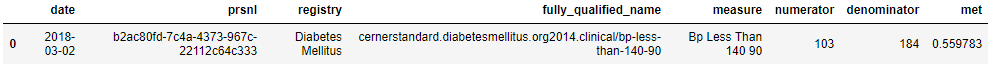

# Part 2. QualiTiers Data

In [36]:
# pick providers to limit it to (based on sheet from LUKE_MO)
org_df = pd.read_csv(org_path,encoding = "ISO-8859-1")
org_df.columns = org_df.columns.str.lower()
org_df.columns = org_df.columns.str.replace(" ","_")
org_df.rename(columns={"personnel_id":"prsnl_id"},inplace=True)
# keep only relevant prsnl
org_df = org_df.loc[org_df['filter']=='Keep']
prsnl_to_limit = org_df.prsnl_id.unique()

In [37]:
raw = pd.read_csv(path,encoding = "ISO-8859-1")
raw.columns = raw.columns.str.lower()
# limit to specified prsnl_id
raw = raw.loc[raw.prsnl_id.isin(prsnl_to_limit)]
# for 3 months in specified querter, put 1st date of each into an array
dates = Benchmarks.dream_dates(raw.year_quarter.unique()[0])
scorable = raw[[
    "date",
    "prsnl_id",
    "fully_qualified_name",
    "numerator",
    "denominator"
]]
# ensure num and den are numeric
# same as scorable[["numerator","denominator"]] = scorable[["numerator","denominator"]].apply(pd.to_numeric)
scorable.loc[:, 'numerator':] = scorable.loc[:, 'numerator':].apply(pd.to_numeric).copy()
qualitiers_table = scorable
# drop fqn where MM% average is 0 or 1
qualitiers_table["mm"] = qualitiers_table.numerator/ qualitiers_table.denominator
met_by_measure = qualitiers_table.groupby(["fully_qualified_name"])["mm"].mean().reset_index().sort_values(["mm"])
fqn_to_drop = met_by_measure.loc[~(met_by_measure.mm==1) | (met_by_measure.mm==0)].fully_qualified_name.unique()
qualitiers_table = qualitiers_table.loc[qualitiers_table.fully_qualified_name.isin(fqn_to_drop)]
qualitiers_table.date = pd.to_datetime(pd.to_datetime(qualitiers_table.date, utc=True).dt.date)
# date check if more than 3 dates; keep earliest for each month
qualitiers_table = Benchmarks.date_check(qualitiers_table,dates)

# make abc 90
abc90 = Benchmarks.abc(Benchmarks.population(Benchmarks.apf(qualitiers_table.groupby([
    'fully_qualified_name',
    'prsnl_id'
])[[
    'numerator',
    'denominator'
]].mean()), ratio = 0.1))
# make abc 50
abc50 = Benchmarks.abc(Benchmarks.population(Benchmarks.apf(qualitiers_table.groupby([
    'fully_qualified_name',
    'prsnl_id'
])[[
    'numerator',
    'denominator'
]].mean()), ratio = 0.5))
# join them
abc = abc90.join(abc50, lsuffix = '_90', rsuffix = '_50')
# calculate avg MM for each prsnl_id for each fqn
s = qualitiers_table.groupby([
    'fully_qualified_name',
    'prsnl_id'
])[[
    'numerator',
    'denominator'
]].mean().apply(lambda x : x['numerator'] / x['denominator'], axis = 1)
#creating a df for tier 1, empty
tiers = pd.DataFrame(index = s.index.get_level_values('fully_qualified_name').unique(), columns = [
    'tier3'
])
# join to abc
tiers = tiers.join(abc)
#Benchmarks.tiers function is where tier 3 is getting created
for fully_qualified_name in s.index.get_level_values('fully_qualified_name').unique():
    tiers.loc[fully_qualified_name, 'tier3'] = Benchmarks.tiers(s.loc[fully_qualified_name])
# rename columns to reflect tiers
tiers = tiers[[
    'tier3',
    'abc_50',
    'abc_90'
]].rename(columns = {
    'abc_50' : 'tier2',
    'abc_90' : 'tier1'
})
# join the prsnl_id MM to the QualiTiers
st = s.reset_index('prsnl_id').join(tiers).rename(columns = {
    0 : 'measure_met'
})
# classify prsnl_id by their tier
st['tier'] = np.where(st.measure_met >= st.tier1, 'tier1', np.where(st.measure_met >= st.tier2, 'tier2', np.where(st.measure_met >= st.tier3, 'tier3', 'bottom')))
# make bottom ABC be 0
tiers['bottom'] = 0
# Count prsnl in each of the Tiers
st = st.groupby([
    'fully_qualified_name',
    'tier'
]).agg({
    'prsnl_id' : pd.Series.nunique
}).rename(columns = {
    'prsnl_id' : 'prsnl_count'
}).stack().unstack('tier').reset_index(1, drop = True).fillna(0)
# stack tiers df
tiers = tiers.stack().to_frame('values')
# stack the prsnl_count dataframe
st = st.stack().to_frame('prsnl_count')
tiers.index.rename('tier', level = 1, inplace = True)
# join prsnl_counts & tier values
formatted_df = st.join(tiers).reset_index()
# join measure from raw_df
formatted_df = formatted_df.merge(raw[["fully_qualified_name","registry","measure"]])
# format as int and percent
formatted_df['values'] = ((formatted_df['values']).astype(float)*100).round(1).astype(str) + '%'
formatted_df['prsnl_count'] = (formatted_df['prsnl_count']).astype(int)
# remove duplicate rows
formatted_df.drop_duplicates(inplace=True)
# rearrange columns
f_df = formatted_df[[
    "fully_qualified_name",
    "registry",
    "measure",
    "tier",
    "prsnl_count",
    "values"
]]
# join tiers and prsnl_counts df
st = st.join(tiers).unstack().stack(0).sort_index(level = [0,1], ascending = [True, False])
# make numeric
st = st.apply(pd.to_numeric)
# reorder
st = st[['bottom', 'tier3', 'tier2', 'tier1']]

C:\Users\ao054198\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ao054198\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Part 3. Powerpoint

In [38]:
# make table with t_test, registry, measure
slide_t_test = t_test.loc[registries_list, :].dropna()

# format
stat_t = round((stat_unstack_i.loc[:, (slice(None), [
    'count',
    'lci',
    'mean',
    'std',
    'uci'
])]), 3).copy().stack('date').reset_index(level = 'date')

# add t_stat and p_value
stat_t['t_stat'], stat_t['p_value'] = round(slide_t_test.t_stat.copy(), 5), round(slide_t_test.p_value.copy(), 5)

# add significance indicator and difference
stat_t['significant'], stat_t['difference'] = stat_t.p_value.copy() < 0.05, round(stat_t.loc[stat_t.date == stat_t.date.max(), 'mean'].copy() - stat_t.loc[stat_t.date == stat_t.date.min(), 'mean'].copy(), 3)

stat_t.dropna(inplace = True)

In [39]:
# define histogram dataframe
h = df_i[(df_i.registry != 'All') & (df_i.measure != 'All')].pivot_table(index = [
    'registry',
    'measure',
    'prsnl'
], columns = 'date', values = 'met').reset_index(level = 'prsnl', drop = True)

# define bins
bins = [x/100 for x in range(0, 101, 5)]

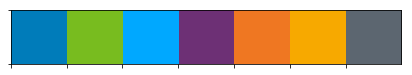

In [40]:
# define new cerner colors
cerner_colors = ['#007cba', # Blue 1 (0,124,186)
                 '#78bc1f', # Green (119,188,31)
                 '#00a8ff', # Blue 2 (0,168,255)
                 '#6d3075', # Purple (109,48,117)
                 '#ef7722', # Orange (239,118,34)
                 '#f7a900', # Yellow (247,168,0)
                 '#5c6670'] # Gray (92,102,112)

# Set current color palette
sns.set_palette(cerner_colors)

# Show color palette
sns.palplot(sns.color_palette()) 

In [41]:
# rename dates to month_name year
dt_name_cols = [dt_min_name,dt_max_name]

In [42]:
# set codes for PPTX Table Styles
medium_1_accent_3 = "{1FECB4D8-DB02-4DC6-A0A2-4F2EBAE1DC90}"
no_style_no_grid = "{2D5ABB26-0587-4C30-8999-92F81FD0307C}"

## 3A. Try One Measure

In [43]:
# reg = 'Hypertension'
# meas = 'Bp Less Than 140 90'
# # open pptx from Cerner Standard Template
# prs = p2p.Presentation(r"\\mustang\workops_pub\Pop Health\DataWorks\Data Insights\Personal Working Folders\Alex\PowerPoint Templates\Cerner Brand Template 2.7.20 With Automation Slides.pptx".replace('\\','/'))

# ############ ############ ############ 
# # REGISTRY # # REGISTRY # # REGISTRY # 
# ############ ############ ############ 
# # For each Registry in the dataset...
# ###################################
# ## A. ADD REGISTRY DIVIDER SLIDE ##
# ###################################

# # select Blue Divider from Slide Master
# primary_content = prs.slide_layouts[30]

# # add slide
# slide = prs.slides.add_slide(primary_content)

# ################################
# ## A.1 TITLE REGISTRY DIVIDER ##
# ################################

# # select title box
# title_box = slide.shapes[0]
# text_frame = title_box.text_frame
# p = text_frame.paragraphs[0]

# # add registry, then bold & color
# run = p.add_run()
# run.text = reg
# font = run.font
# font.bold = True

# ###################################
# ## B. ADD REGISTRY SUMMARY SLIDE ##
# ###################################

# # save slide from layout 2 in Slide Master
# primary_content = prs.slide_layouts[13]

# # add slide
# slide = prs.slides.add_slide(primary_content)

# abc_text_box = slide.shapes[2]
# abc_text_box.element.getparent().remove(abc_text_box.element)
# ######################
# ## B.1 ADD RS TITLE ##
# ######################

# # select title box
# title_box = slide.shapes[0]
# text_frame = title_box.text_frame
# p = text_frame.paragraphs[0]

# # add registry, then bold & color
# run = p.add_run()
# run.text = reg
# font = run.font
# font.bold = True
# font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
# # add text
# run = p.add_run()
# run.text = " Provider Performance"
# font = run.font

# ###############################
# ## B.2 CREATE & ADD RS TABLE ##
# ###############################

# ## Make Registry Summary Table from "Current State" dataframe
# reg_summary = cs.loc[cs.Registry==reg]
# reg_summary = reg_summary.loc[reg_summary.Measure!="All"]
# reg_summary.drop(columns="Registry",inplace=True)

# # assign to "my_table" variable
# my_table = reg_summary

# # convert column names to titlecase
# my_table.columns = my_table.columns.str.title()

# rows, columns = my_table.shape

# #### Create Table Slide 1 ####
# shapes = slide.shapes
# table_placeholder = slide.shapes[1]
# shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
# table = shape.table

# ##########################
# ## B.2.1 TITLE RS TABLE ##
# ##########################

# # loop through all columns in df and insert as 0th row
# for col in range(columns):
#     cell = table.cell(0,col)
#     p = cell.text_frame.paragraphs[0]
#     # add the tier name in bold
#     run = p.add_run()
#     # specify the font size
#     font = run.font
#     font.size = Pt(18)
#     # add text from table columns
#     run.text = my_table.columns[col]
#     # center and middle text
#     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     cell.vertical_anchor = MSO_ANCHOR.MIDDLE

# #########################
# ## B.2.2 FILL RS TABLE ##
# #########################

# # look through all values in table (exluding 0th row)
# m = my_table.values
# for row in range(rows):
#         for col in range(columns):
#             val = m[row, col]
#             cell = table.cell(row+1,col)
#             p = cell.text_frame.paragraphs[0]
#             # add the tier name in bold
#             run = p.add_run()
#             # specify the font size
#             font = run.font
#             font.size = Pt(18)
#             # add text from table, accounting for name row
#             run.text = str(my_table.iloc[row,col])
#             # Middle all text; Left align if measure, otherwise center
#             cell.vertical_anchor = MSO_ANCHOR.MIDDLE
#             if col is 0:
#                     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
#             else:
#                 cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

# # format table style
# tbl =  shape._element.graphic.graphicData.tbl
# style_id = medium_1_accent_3
# tbl[0][-1].text = style_id

# # # # ############     ############     ############ # # # #
# # # # # MEASURES #     # MEASURES #     # MEASURES # # # # #
# # # # ############     ############     ############ # # # #

# ############################
# ## A. ADD TRENDING SLIDES ##
# ############################

# # save slide from layout 9 in Slide Master
# primary_content = prs.slide_layouts[11]

# # add slide
# slide1 = prs.slides.add_slide(primary_content)
# # add slide 2
# slide2 = prs.slides.add_slide(primary_content)

# ###################
# ## A.1 CREATE DF ##
# ###################

# # make table
# ttable = formatted.reset_index()
# slicet = ttable.loc[(ttable["measure"]==meas) & (ttable["registry"]==reg)]
# means = slicet[[dt_min+"_mean",dt_max+"_mean"]]
# stds = slicet[[dt_min+"_std",dt_max+"_std"]]
# conf_ints = slicet[[dt_min+"_conf_int",dt_max+"_conf_int"]]
# stats_r = slicet[["t_stat","df","p_value"]]
# # columns
# means.columns = dt_name_cols
# stds.columns = dt_name_cols
# conf_ints.columns = dt_name_cols
# stats_r.columns = [""]+dt_name_cols
# # formatting
# means.insert(0,"",['Mean Met %'])
# stds.insert(0,"",['Standard Dev.'])
# conf_ints.insert(0,"",['95% CI'])
# table_for_trend = pd.concat([means,stds,conf_ints,stats_r])

# # assign to "my_table" variable
# my_table = table_for_trend

# # convert column names to titlecase
# my_table.columns = my_table.columns.str.title()

# rows, columns = my_table.shape

# ##########################
# ## A.2 CREATE HISTOGRAM ##
# ##########################

# # set default style for visual
# style.use('default')

# # make figure, plot
# fig1, ax1 = plt.subplots(figsize = (5, 5))
# # create plot
# h.loc[(reg, meas)].plot.hist(ax = ax1, bins = bins, **{
#     'alpha' : 0.6
# }, color = [cerner_colors[0], cerner_colors[1]]).xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))
# #             remove y-label
# ax1.set_ylabel('')
# #             change font size of ticks
# ax1.tick_params(axis = 'both', labelsize = 10, pad = 2.5)
# #             set legend
# ax1.legend(loc = 'upper left', prop = {
#     'size' : 10
# })
# ax1.grid(axis='x')
# #             save figure
# fig1.savefig('hist_fig.png', dpi = 500)
# #             close fig
# plt.close(fig1)

# ####################
# ## A.3 CREATE KDE ##
# ####################

# # set default style for visual
# style.use('default')

# #             make figure, plot
# fig2, ax2 = plt.subplots(figsize = (5, 5))
# #             create plot
# sns.distplot(ax = ax2, a = h.loc[(reg, meas), h.columns[0]], color = cerner_colors[0], bins = bins, hist = False, label = h.columns[0])
# sns.distplot(ax = ax2, a = h.loc[(reg, meas), h.columns[1]], color = cerner_colors[1], bins = bins, hist = False, label = h.columns[1]).xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))
# #             remove x-label
# ax2.set_xlabel('')
# #             set x-lim
# ax2.set_xlim(xmin = 0, xmax = 1)
# #             change font size of ticks
# ax2.tick_params(axis = 'both', labelsize = 10, pad = 2.5)
# #             set legend
# ax2.legend(loc = 'upper left', prop = {
#     'size' : 10
# })
# ax2.grid(axis='x')
# #             save figure
# fig2.savefig('kde_fig.png', dpi = 500)
# #             close fig
# plt.close(fig2)

# #############################
# ## A.4 ADD HISTOGRAM & KDE ##
# #############################

# # insert Histogram
# slide1.shapes[4].insert_picture('hist_fig.png')

# # insert KDE
# slide2.shapes[4].insert_picture('kde_fig.png')

# #############################
# ## A.5 ADD DUPLICATE ITEMS ##
# #############################

# trending_slides = [slide1, slide2]
# for slide in trending_slides:
    
#     ########################
#     ## A.5.1 ADD TS TITLE ##
#     ########################

#     # select title box
#     title_box = slide.shapes[0]
#     text_frame = title_box.text_frame
#     p = text_frame.paragraphs[0]

#     # add registry, then bold & color
#     run = p.add_run()
#     run.text = reg
#     font = run.font
#     font.bold = True
#     font.color.theme_color = MSO_THEME_COLOR.ACCENT_1    
#     # add measure
#     run = p.add_run()
#     run.text = " "+meas
#     font = run.font

#     ################################
#     ## A.5.2 ADD TS ANALYSIS TEXT ##
#     ################################

#     # select text box
#     title_box = slide.shapes[1]
#     text_frame = title_box.text_frame
#     p = text_frame.paragraphs[0]
#     # add initial text
#     run = p.add_run()
#     run.text = formatted.loc[(reg,meas),"initial_text"]
#     font = run.font
#     # specify the font size
#     font.size = Pt(23)
#     # make not bold
#     font.bold = False
#     # add change text
#     run = p.add_run()
#     run.text = formatted.loc[(reg,meas),"change_text"]
#     font = run.font
#     # specify the font size
#     font.size = Pt(23)
#     # conditionally bold and color text
#     if table_for_trend.iloc[3,2] == 'p-value: <0.05':
#         font.bold = True
#         font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
#     else:
#         font.bold = False        
#     # add final text
#     run = p.add_run()
#     font = run.font
#     # specify the font size
#     font.size = Pt(23)
#     run.text = " "+ formatted.loc[(reg,meas),"final_text"]
#     # make not bold
#     font.bold = False

#     ########################
#     ## A.5.3 ADD TS TABLE ##
#     ########################
#     shapes = slide.shapes
#     table_placeholder = slide.shapes[2]
#     shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
#     table = shape.table

#     #########################
#     ## A.5.3.1 TITLE TABLE ##
#     #########################

#     # loop through all columns in df and insert as 0th row
#     for col in range(columns):
#         cell = table.cell(0,col)
#         p = cell.text_frame.paragraphs[0]
#         # add the tier name in bold
#         run = p.add_run()
#         font = run.font
#         # specify the font size
#         font.size = Pt(18)
#         # add text from table columns
#         run.text = my_table.columns[col]
#         # center and middle text
#         cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#         cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     ########################
#     ## A.5.3.2 FILL TABLE ##
#     ########################

#     # look through all values in table (exluding 0th row)
#     m = my_table.values
#     for row in range(rows):
#             for col in range(columns):
#                 val = m[row, col]
#                 cell = table.cell(row+1,col)
#                 p = cell.text_frame.paragraphs[0]
#                 # add the text as run
#                 run = p.add_run()
#                 # specify the font size
#                 font = run.font
#                 font.size = Pt(18)
#                 # add text from table, accounting for name row
#                 run.text = str(my_table.iloc[row,col])
#                 # Middle & Center all text
#                 cell.vertical_anchor = MSO_ANCHOR.MIDDLE
#                 cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#                 if col is 0:
#                     # bold
#                     font = run.font
#                     font.bold = True

#     # format table style
#     tbl =  shape._element.graphic.graphicData.tbl
#     style_id = medium_1_accent_3
#     tbl[0][-1].text = style_id

#     ###########################
#     ## A.6 SIGNIFICANCE TEXT ##
#     ###########################

#     # Add qualifying text if 'not significant'...otherwise remove placeholder object
#     if table_for_trend.iloc[3,2] == 'p-value: <0.05':
#         cp = slide.shapes[3]
#         cp.element.getparent().remove(cp.element)
#     else: 
#         sig_text='*not statistically significant'
#         slide.shapes[3].text = sig_text
        
# #############################
# ## B. ADD QUALITIERS SLIDE ##
# #############################

# # Make table in background (if applicable)
# f_new = f_df.loc[f_df.registry==reg]
# if meas in f_new.loc[f_new.measure==meas].measure.unique():
#     f_new = f_new.loc[f_new.measure==meas]
#     fqn = f_new.fully_qualified_name.unique()[0]
#     f_new.replace("nan%","NA",inplace=True)


#     # save slide from layout 9 in Slide Master
#     primary_content = prs.slide_layouts[12]

#     # add slide
#     slide = prs.slides.add_slide(primary_content)

#     ##############################
#     ## B.1 ADD QUALITIERS TITLE ##
#     ##############################

#     # select title box
#     title_box = slide.shapes[0]
#     text_frame = title_box.text_frame
#     p = text_frame.paragraphs[0]

#     # add registry, then bold & color
#     run = p.add_run()
#     run.text = reg
#     font = run.font
#     font.bold = True
#     font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
#     # add measure
#     run = p.add_run()
#     run.text = " "+f_new.measure.unique()[0]
#     font = run.font
    
#     ###################################
#     ## B.2 ADD & FILL PROVIDER TABLE ##
#     ###################################

#     # add logic if any tier is NaN (Tier 3 Specifically)

#     # ADD TABLE
#     shapes = slide.shapes
#     table_placeholder = slide.shapes[3]
#     shape = table_placeholder.insert_table(rows=10, cols=1)
#     table = shape.table

#     # FILL THE TABLE
#     cell = table.cell(0, 0)
#     p = cell.text_frame.paragraphs[0]
#     # add the tier name in bold
#     run = p.add_run()
#     run.text = f_new.loc[f_new.tier=='tier1'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
#     font = run.font
#     font.size = Pt(28)
#     # center and middle text
#     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     ## TIER
#     # select cell text
#     cell = table.cell(1, 0)
#     p = cell.text_frame.paragraphs[0]
#     # add the tier name in bold
#     run = p.add_run()
#     run.text = "Tier 1: "
#     font = run.font
#     font.size = Pt(24)
#     font.bold = True
#     # add bold & blue percent
#     run = p.add_run()
#     run.text = f_new.loc[f_new.tier=='tier1'][["values"]].iloc[0,0]
#     font = run.font
#     font.bold = True
#     font.size = Pt(24)
#     font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
#     # center and middle text
#     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     ## PROVIDERS
#     cell = table.cell(3, 0)
#     p = cell.text_frame.paragraphs[0]
#     # add the tier name in bold
#     run = p.add_run()
#     run.text = f_new.loc[f_new.tier=='tier2'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
#     font = run.font
#     font.size = Pt(28)
#     # center and middle text
#     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     ## TIER
#     # select cell text
#     cell = table.cell(4, 0)
#     p = cell.text_frame.paragraphs[0]
#     # add the tier name in bold
#     run = p.add_run()
#     run.text = "Tier 2: "
#     font = run.font
#     font.size = Pt(24)
#     font.bold = True
#     # add bold & blue percent
#     run = p.add_run()
#     run.text = f_new.loc[f_new.tier=='tier2'][["values"]].iloc[0,0]
#     font = run.font
#     font.bold = True
#     font.size = Pt(24)
#     font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
#     # center and middle text
#     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     ## PROVIDERS
#     cell = table.cell(6, 0)
#     p = cell.text_frame.paragraphs[0]
#     # add the tier name in bold
#     run = p.add_run()
#     run.text = f_new.loc[f_new.tier=='tier3'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
#     font = run.font
#     font.size = Pt(28)
#     # center and middle text
#     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     ## TIER
#     # select cell text
#     cell = table.cell(7, 0)
#     p = cell.text_frame.paragraphs[0]
#     # add the tier name in bold
#     run = p.add_run()
#     run.text = "Tier 3: "
#     font = run.font
#     font.size = Pt(24)
#     font.bold = True
#     # add bold & blue percent
#     run = p.add_run()
#     run.text = f_new.loc[f_new.tier=='tier3'][["values"]].iloc[0,0]
#     font = run.font
#     font.bold = True
#     font.size = Pt(24)
#     font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
#     # center and middle text
#     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     ## PROVIDERS
#     cell = table.cell(9, 0)
#     p = cell.text_frame.paragraphs[0]
#     # add the tier name in bold
#     run = p.add_run()
#     run.text = f_new.loc[f_new.tier=='bottom'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
#     font = run.font
#     font.size = Pt(28)
#     # center and middle text
#     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#     cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     # format table style
#     tbl =  shape._element.graphic.graphicData.tbl
#     style_id = no_style_no_grid
#     tbl[0][-1].text = style_id
    
#     #################################
#     ## B.3 ADD & FILL TARGET TABLE ##
#     #################################
    
#     # Create QualiTiers_Benchmark dataframe
#     tier3 = f_new.loc[f_new.tier=='tier3'][["values"]].values[0]
#     tier2 = f_new.loc[f_new.tier=='tier2'][["values"]].values[0]
#     tier1 = f_new.loc[f_new.tier=='tier1'][["values"]].values[0]
#     qualitiers_data = {
#         'Method':['Scorecard Target',"QualiTiers"],
#         'Tier 3':['-',tier3[0]],
#         'Tier 2':['-',tier2[0]],
#         'Tier 1':['-',tier1[0]]
#     }
#     qualitiers_table = pd.DataFrame(qualitiers_data)    

#     my_table = qualitiers_table
#     rows, columns = my_table.shape
    
#     # Add Empty Table
#     table_placeholder = slide.shapes[2]
#     shape = table_placeholder.insert_table(rows=3, cols=4)
#     table = shape.table

#     # Title Table
#     # loop through all columns in df and insert as 0th row
#     for col in range(columns):
#         cell = table.cell(0,col)
#         p = cell.text_frame.paragraphs[0]
#         # add the tier name in bold
#         run = p.add_run()
#         font = run.font
#         # specify the font size
#         font.size = Pt(18)
#         # add text from table columns
#         run.text = my_table.columns[col]
#         # center and middle text
#         cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#         cell.vertical_anchor = MSO_ANCHOR.MIDDLE
        
    
#     # look through all values in table (exluding 0th row)
#     m = my_table.values
#     for row in range(rows):
#             for col in range(columns):
#                 val = m[row, col]
#                 cell = table.cell(row+1,col)
#                 p = cell.text_frame.paragraphs[0]
#                 # add the text as run
#                 run = p.add_run()
#                 # specify the font size
#                 font = run.font
#                 font.size = Pt(18)
#                 # add text from table, accounting for name row
#                 run.text = str(my_table.iloc[row,col])
#                 # Middle & Center all text
#                 cell.vertical_anchor = MSO_ANCHOR.MIDDLE
#                 cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                    
#     # format table style
#     tbl =  shape._element.graphic.graphicData.tbl
#     style_id = medium_1_accent_3
#     tbl[0][-1].text = style_id

#     ########################################
#     ## B.4 CREATE & ADD QUALITIERS VISUAL ##
#     ########################################

#     # format QualiTiers Visual
#     style.use('fivethirtyeight')
#     mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cerner_colors)
#     %matplotlib inline

#     ax = Benchmarks.tier_plot(s.loc[fqn], 
#                               st.loc[(fqn, 'values'), 'tier1'], 
#                               st.loc[(fqn, 'values'), [
#         'tier2',
#         'tier3'
#     ]], 
#         title=fqn.rsplit('/',1)[-1].replace("-"," ").title())

#     ax.savefig
#     ax.savefig('test_fig.png', dpi = 500)
#     #             close fig
#     plt.close(ax)
#     # insert picture
#     slide.shapes[1].insert_picture('test_fig.png')

# ######################################
# ## D.1 CONDITIONALLY ADD TPv2 SLIDE ##
# ######################################

# top = df.loc[(df.registry==reg) & (df.measure==meas) & (df.date==df.date.max())]

# # parse out the fully_qualified_name (assuming there is only 1)
# fqn = top.fully_qualified_name.unique()[0]

# # find tier 1
# t1 = tiers.reset_index()

# # IF fully_qualified_name HAS Tiers
# if fqn in t1.fully_qualified_name.unique():
#     # save slide from layout 9 in Slide Master
#     primary_content = prs.slide_layouts[13]

#     # add slide
#     slide = prs.slides.add_slide(primary_content)

#     #########################
#     ## D.2 CREATE TP TABLE ##
#     #########################

#     ## make Tier 3 Table
#     tier_1 = t1.loc[(t1.fully_qualified_name==fqn) & (t1.tier=='tier1')]['values'].unique()[0]
#     # subset providers with above avg Tier 1
#     top = top.loc[(top.met>=tier_1)]
#     top = top[[
#         "prsnl",
#         "org_name",
#         "met",
#         "denominator"
#     ]].sort_values(["met"],ascending=False).drop_duplicates()
#     # format table
#     top['met'] = ((top['met'])*100).round(1).astype(str) + '%'
#     top.rename(columns = {
#         'prsnl' : 'Provider',
#         'org_name' : 'Organization', 
#         'met' : 'MM%',
#         'denominator' : 'Den'
#     }, inplace = True)

#     # assign to "my_table" variable
#     my_table = top

#     rows, columns = my_table.shape


#     ##################
#     ## D.3 TITLE TP ##
#     ##################

#     # select title box
#     title_box = slide.shapes[0]
#     text_frame = title_box.text_frame
#     p = text_frame.paragraphs[0]

#     # add registry, then bold & color
#     run = p.add_run()
#     run.text = reg
#     font = run.font
#     font.bold = True
#     font.color.theme_color = MSO_THEME_COLOR.ACCENT_1

#     # add measure
#     run = p.add_run()
#     run.text = " "+meas
#     font = run.font

#     #### Create Table Slide 1 ####
#     shapes = slide.shapes
#     table_placeholder = slide.shapes[1]
#     shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
#     table = shape.table

#     ########################
#     # D.4 TITLE TP TABLE #
#     ########################

#     # loop through all columns in df and insert as 0th row
#     for col in range(columns):
#         cell = table.cell(0,col)
#         p = cell.text_frame.paragraphs[0]
#         # add the tier name in bold
#         run = p.add_run()
#         font = run.font
#         font.size = Pt(18)
#         # add text from table columns
#         run.text = my_table.columns[col]
#         # center and middle text
#         cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
#         cell.vertical_anchor = MSO_ANCHOR.MIDDLE

#     #################
#     # D.5 FILL TP TABLE #
#     #################

#     # look through all values in table (exluding 0th row)
#     m = my_table.values
#     for row in range(rows):
#             for col in range(columns):
#                 val = m[row, col]
#                 cell = table.cell(row+1,col)
#                 p = cell.text_frame.paragraphs[0]
#                 # add the tier name in bold
#                 run = p.add_run()
#                 # add text from table, accounting for name row
#                 run.text = str(my_table.iloc[row,col])
#                 font = run.font
#                 font.size = Pt(18)
                
#                 # Middle all text; Left align if measure, otherwise center
#                 cell.vertical_anchor = MSO_ANCHOR.MIDDLE
#                 if col is 0:
#                         cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
#                 else:
#                     cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

#     # format table style
#     tbl =  shape._element.graphic.graphicData.tbl
#     style_id = medium_1_accent_3
#     tbl[0][-1].text = style_id

#     #####################
#     ## D.6 TP ABC TEXT ##
#     #####################

#     # select title box
#     title_box = slide.shapes[2]
#     text_frame = title_box.text_frame
#     p = text_frame.paragraphs[0]

#     run = p.add_run()
#     run.text = str(my_table.Provider.nunique()) + " providers exceeding the "
#     font = run.font

#     # add registry, then bold & color
#     run = p.add_run()
#     run.text = 'Achievable Benchmark of Care '
#     font = run.font
#     font.bold = True
#     font.color.theme_color = MSO_THEME_COLOR.ACCENT_1

#     run = p.add_run()
#     run.text = "of "
#     font = run.font

#     run = p.add_run()
#     run.text = str(round((tier_1*100),1)) + '%'
#     font = run.font
#     font.bold = True
#     text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

# ##########
# ## SAVE ##
# ##########
# # save pptx
# save_path = f"{client}_New_Template_Analysis_Test.pptx"
# prs.save(save_path)
# print(f"Finished {reg}, {meas}")
# print(f"{reg} complete")
# print(f"Done with {client}! Saved as '{save_path}'")

## 3B. Loop Through All Registries & Measures

In [48]:
# open pptx from Cerner Standard Template
prs = p2p.Presentation(r"\\mustang\workops_pub\Pop Health\DataWorks\Data Insights\Personal Working Folders\Alex\PowerPoint Templates\Cerner Brand Template 2.11.20 With Automation Slides.pptx".replace('\\','/'))

############ ############ ############ 
# REGISTRY # # REGISTRY # # REGISTRY # 
############ ############ ############ 
# For each Registry in the dataset...
for reg in stat_t.index.get_level_values(0).unique():
    # For each Registry in the dataset...
    ###################################
    ## A. ADD REGISTRY DIVIDER SLIDE ##
    ###################################

    # select Blue Divider from Slide Master
    primary_content = prs.slide_layouts[30]

    # add slide
    slide = prs.slides.add_slide(primary_content)

    ################################
    ## A.1 TITLE REGISTRY DIVIDER ##
    ################################

    # select title box
    title_box = slide.shapes[0]
    text_frame = title_box.text_frame
    p = text_frame.paragraphs[0]

    # add registry, then bold & color
    run = p.add_run()
    run.text = reg
    font = run.font
    font.bold = True

    ###################################
    ## B. ADD REGISTRY SUMMARY SLIDE ##
    ###################################

    # save slide from layout 2 in Slide Master
    primary_content = prs.slide_layouts[13]

    # add slide
    slide = prs.slides.add_slide(primary_content)

    abc_text_box = slide.shapes[2]
    abc_text_box.element.getparent().remove(abc_text_box.element)
    ######################
    ## B.1 ADD RS TITLE ##
    ######################

    # select title box
    title_box = slide.shapes[0]
    text_frame = title_box.text_frame
    p = text_frame.paragraphs[0]

    # add registry, then bold & color
    run = p.add_run()
    run.text = reg
    font = run.font
    font.bold = True
    font.color.theme_color = MSO_THEME_COLOR.BACKGROUND_2
    # add text
    run = p.add_run()
    run.text = " Provider Performance"
    font = run.font

    ###############################
    ## B.2 CREATE & ADD RS TABLE ##
    ###############################

    ## Make Registry Summary Table from "Current State" dataframe
    reg_summary = cs.loc[cs.Registry==reg]
    reg_summary = reg_summary.loc[reg_summary.Measure!="All"]
    reg_summary.drop(columns="Registry",inplace=True)

    # assign to "my_table" variable
    my_table = reg_summary

    # convert column names to titlecase
    my_table.columns = my_table.columns.str.title()

    rows, columns = my_table.shape

    #### Create Table Slide 1 ####
    shapes = slide.shapes
    table_placeholder = slide.shapes[1]
    shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
    table = shape.table

    ##########################
    ## B.2.1 TITLE RS TABLE ##
    ##########################

    # loop through all columns in df and insert as 0th row
    for col in range(columns):
        cell = table.cell(0,col)
        p = cell.text_frame.paragraphs[0]
        # add the tier name in bold
        run = p.add_run()
        # specify the font size
        font = run.font
        font.size = Pt(18)
        # add text from table columns
        run.text = my_table.columns[col]
        # center and middle text
        cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
        cell.vertical_anchor = MSO_ANCHOR.MIDDLE

    #########################
    ## B.2.2 FILL RS TABLE ##
    #########################

    # look through all values in table (exluding 0th row)
    m = my_table.values
    for row in range(rows):
            for col in range(columns):
                val = m[row, col]
                cell = table.cell(row+1,col)
                p = cell.text_frame.paragraphs[0]
                # add the tier name in bold
                run = p.add_run()
                # specify the font size
                font = run.font
                font.size = Pt(18)
                # add text from table, accounting for name row
                run.text = str(my_table.iloc[row,col])
                # Middle all text; Left align if measure, otherwise center
                cell.vertical_anchor = MSO_ANCHOR.MIDDLE
                if col is 0:
                        cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
                else:
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

    # format table style
    tbl =  shape._element.graphic.graphicData.tbl
    style_id = medium_1_accent_3
    tbl[0][-1].text = style_id

    # # # ############     ############     ############ # # # #
    # # # # MEASURES #     # MEASURES #     # MEASURES # # # # #
    # # # ############     ############     ############ # # # #
    
    # For each Measure in the dataset...
    for meas in stat_t.loc[reg].index.unique():
    #    for meas in stat_t.loc[reg].index.unique():
        if meas != 'All':
            if meas in measures_list:
                #
                #
                ############################
                ## A. ADD TRENDING SLIDES ##
                ############################

                # save slide from layout 9 in Slide Master
                primary_content = prs.slide_layouts[11]

                # add slide
                slide1 = prs.slides.add_slide(primary_content)
                # add slide 2
                slide2 = prs.slides.add_slide(primary_content)

                ###################
                ## A.1 CREATE DF ##
                ###################

                # make table
                ttable = formatted.reset_index()
                slicet = ttable.loc[(ttable["measure"]==meas) & (ttable["registry"]==reg)]
                means = slicet[[dt_min+"_mean",dt_max+"_mean"]]
                stds = slicet[[dt_min+"_std",dt_max+"_std"]]
                conf_ints = slicet[[dt_min+"_conf_int",dt_max+"_conf_int"]]
                stats_r = slicet[["t_stat","df","p_value"]]
                # columns
                means.columns = dt_name_cols
                stds.columns = dt_name_cols
                conf_ints.columns = dt_name_cols
                stats_r.columns = [""]+dt_name_cols
                # formatting
                means.insert(0,"",['Mean Met %'])
                stds.insert(0,"",['Standard Dev.'])
                conf_ints.insert(0,"",['95% CI'])
                table_for_trend = pd.concat([means,stds,conf_ints,stats_r])

                # assign to "my_table" variable
                my_table = table_for_trend

                # convert column names to titlecase
                my_table.columns = my_table.columns.str.title()

                rows, columns = my_table.shape

                ##########################
                ## A.2 CREATE HISTOGRAM ##
                ##########################

                # set default style for visual
                style.use('default')

                # make figure, plot
                fig1, ax1 = plt.subplots(figsize = (5, 5))
                # create plot
                h.loc[(reg, meas)].plot.hist(ax = ax1, bins = bins, **{
                    'alpha' : 0.6
                }, color = [cerner_colors[0], cerner_colors[1]]).xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))
                #             remove y-label
                ax1.set_ylabel('')
                #             change font size of ticks
                ax1.tick_params(axis = 'both', labelsize = 10, pad = 2.5)
                #             set legend
                ax1.legend(loc = 'upper left', prop = {
                    'size' : 10
                })
                ax1.grid(axis='x')
                #             save figure
                fig1.savefig('hist_fig.png', dpi = 500)
                #             close fig
                plt.close(fig1)

                ####################
                ## A.3 CREATE KDE ##
                ####################

                # set default style for visual
                style.use('default')

                #             make figure, plot
                fig2, ax2 = plt.subplots(figsize = (5, 5))
                #             create plot
                sns.distplot(ax = ax2, a = h.loc[(reg, meas), h.columns[0]], color = cerner_colors[0], bins = bins, hist = False, label = h.columns[0])
                sns.distplot(ax = ax2, a = h.loc[(reg, meas), h.columns[1]], color = cerner_colors[1], bins = bins, hist = False, label = h.columns[1]).xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1))
                #             remove x-label
                ax2.set_xlabel('')
                #             set x-lim
                ax2.set_xlim(xmin = 0, xmax = 1)
                #             change font size of ticks
                ax2.tick_params(axis = 'both', labelsize = 10, pad = 2.5)
                #             set legend
                ax2.legend(loc = 'upper left', prop = {
                    'size' : 10
                })
                ax2.grid(axis='x')
                #             save figure
                fig2.savefig('kde_fig.png', dpi = 500)
                #             close fig
                plt.close(fig2)

                #############################
                ## A.4 ADD HISTOGRAM & KDE ##
                #############################

                # insert Histogram
                slide1.shapes[4].insert_picture('hist_fig.png')

                # insert KDE
                slide2.shapes[4].insert_picture('kde_fig.png')

                #############################
                ## A.5 ADD DUPLICATE ITEMS ##
                #############################

                trending_slides = [slide1, slide2]
                for slide in trending_slides:

                    ########################
                    ## A.5.1 ADD TS TITLE ##
                    ########################

                    # select title box
                    title_box = slide.shapes[0]
                    text_frame = title_box.text_frame
                    p = text_frame.paragraphs[0]

                    # add registry, then bold & color
                    run = p.add_run()
                    run.text = reg
                    font = run.font
                    font.bold = True
                    font.color.theme_color = MSO_THEME_COLOR.BACKGROUND_2    
                    # add measure
                    run = p.add_run()
                    run.text = " "+meas
                    font = run.font

                    ################################
                    ## A.5.2 ADD TS ANALYSIS TEXT ##
                    ################################

                    # select text box
                    title_box = slide.shapes[1]
                    text_frame = title_box.text_frame
                    p = text_frame.paragraphs[0]
                    # add initial text
                    run = p.add_run()
                    run.text = formatted.loc[(reg,meas),"initial_text"]
                    font = run.font
                    # specify the font size
                    font.size = Pt(23)
                    # make not bold
                    font.bold = False
                    # add change text
                    run = p.add_run()
                    run.text = formatted.loc[(reg,meas),"change_text"]
                    font = run.font
                    # specify the font size
                    font.size = Pt(23)
                    # conditionally bold and color text
                    if table_for_trend.iloc[3,2] == 'p-value: <0.05':
                        font.bold = True
                        font.color.theme_color = MSO_THEME_COLOR.BACKGROUND_2
                    else:
                        font.bold = False        
                    # add final text
                    run = p.add_run()
                    font = run.font
                    # specify the font size
                    font.size = Pt(23)
                    run.text = " "+ formatted.loc[(reg,meas),"final_text"]
                    # make not bold
                    font.bold = False

                    ########################
                    ## A.5.3 ADD TS TABLE ##
                    ########################
                    shapes = slide.shapes
                    table_placeholder = slide.shapes[2]
                    shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
                    table = shape.table

                    #########################
                    ## A.5.3.1 TITLE TABLE ##
                    #########################

                    # loop through all columns in df and insert as 0th row
                    for col in range(columns):
                        cell = table.cell(0,col)
                        p = cell.text_frame.paragraphs[0]
                        # add the tier name in bold
                        run = p.add_run()
                        font = run.font
                        # specify the font size
                        font.size = Pt(18)
                        # add text from table columns
                        run.text = my_table.columns[col]
                        # center and middle text
                        cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                        cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                    ########################
                    ## A.5.3.2 FILL TABLE ##
                    ########################

                    # look through all values in table (exluding 0th row)
                    m = my_table.values
                    for row in range(rows):
                            for col in range(columns):
                                val = m[row, col]
                                cell = table.cell(row+1,col)
                                p = cell.text_frame.paragraphs[0]
                                # add the text as run
                                run = p.add_run()
                                # specify the font size
                                font = run.font
                                font.size = Pt(18)
                                # add text from table, accounting for name row
                                run.text = str(my_table.iloc[row,col])
                                # Middle & Center all text
                                cell.vertical_anchor = MSO_ANCHOR.MIDDLE
                                cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                                if col is 0:
                                    # bold
                                    font = run.font
                                    font.bold = True

                    # format table style
                    tbl =  shape._element.graphic.graphicData.tbl
                    style_id = medium_1_accent_3
                    tbl[0][-1].text = style_id

                    ###########################
                    ## A.6 SIGNIFICANCE TEXT ##
                    ###########################

                    # Add qualifying text if 'not significant'...otherwise remove placeholder object
                    if table_for_trend.iloc[3,2] == 'p-value: <0.05':
                        cp = slide.shapes[3]
                        cp.element.getparent().remove(cp.element)
                    else: 
                        sig_text='*not statistically significant'
                        slide.shapes[3].text = sig_text

                #############################
                ## B. ADD QUALITIERS SLIDE ##
                #############################

                # Make table in background (if applicable)
                f_new = f_df.loc[f_df.registry==reg]
                if meas in f_new.loc[f_new.measure==meas].measure.unique():
                    f_new = f_new.loc[f_new.measure==meas]
                    fqn = f_new.fully_qualified_name.unique()[0]
                    f_new.replace("nan%","NA",inplace=True)


                    # save slide from layout 9 in Slide Master
                    primary_content = prs.slide_layouts[12]

                    # add slide
                    slide = prs.slides.add_slide(primary_content)

                    ##############################
                    ## B.1 ADD QUALITIERS TITLE ##
                    ##############################

                    # select title box
                    title_box = slide.shapes[0]
                    text_frame = title_box.text_frame
                    p = text_frame.paragraphs[0]

                    # add registry, then bold & color
                    run = p.add_run()
                    run.text = reg
                    font = run.font
                    font.bold = True
                    font.color.theme_color = MSO_THEME_COLOR.BACKGROUND_2
                    # add measure
                    run = p.add_run()
                    run.text = " "+f_new.measure.unique()[0]
                    font = run.font

                    ###################################
                    ## B.2 ADD & FILL PROVIDER TABLE ##
                    ###################################

                    # add logic if any tier is NaN (Tier 3 Specifically)

                    # ADD TABLE
                    shapes = slide.shapes
                    table_placeholder = slide.shapes[3]
                    shape = table_placeholder.insert_table(rows=10, cols=1)
                    table = shape.table

                    # FILL THE TABLE
                    cell = table.cell(0, 0)
                    p = cell.text_frame.paragraphs[0]
                    # add the tier name in bold
                    run = p.add_run()
                    run.text = f_new.loc[f_new.tier=='tier1'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
                    font = run.font
                    font.size = Pt(28)
                    # center and middle text
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                    cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                    ## TIER
                    # select cell text
                    cell = table.cell(1, 0)
                    p = cell.text_frame.paragraphs[0]
                    # add the tier name in bold
                    run = p.add_run()
                    run.text = "Tier 1: "
                    font = run.font
                    font.size = Pt(24)
                    font.bold = True
                    # add bold & blue percent
                    run = p.add_run()
                    run.text = f_new.loc[f_new.tier=='tier1'][["values"]].iloc[0,0]
                    font = run.font
                    font.bold = True
                    font.size = Pt(24)
                    font.color.theme_color = MSO_THEME_COLOR.BACKGROUND_2
                    # center and middle text
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                    cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                    ## PROVIDERS
                    cell = table.cell(3, 0)
                    p = cell.text_frame.paragraphs[0]
                    # add the tier name in bold
                    run = p.add_run()
                    run.text = f_new.loc[f_new.tier=='tier2'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
                    font = run.font
                    font.size = Pt(28)
                    # center and middle text
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                    cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                    ## TIER
                    # select cell text
                    cell = table.cell(4, 0)
                    p = cell.text_frame.paragraphs[0]
                    # add the tier name in bold
                    run = p.add_run()
                    run.text = "Tier 2: "
                    font = run.font
                    font.size = Pt(24)
                    font.bold = True
                    # add bold & blue percent
                    run = p.add_run()
                    run.text = f_new.loc[f_new.tier=='tier2'][["values"]].iloc[0,0]
                    font = run.font
                    font.bold = True
                    font.size = Pt(24)
                    font.color.theme_color = MSO_THEME_COLOR.BACKGROUND_2
                    # center and middle text
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                    cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                    ## PROVIDERS
                    cell = table.cell(6, 0)
                    p = cell.text_frame.paragraphs[0]
                    # add the tier name in bold
                    run = p.add_run()
                    run.text = f_new.loc[f_new.tier=='tier3'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
                    font = run.font
                    font.size = Pt(28)
                    # center and middle text
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                    cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                    ## TIER
                    # select cell text
                    cell = table.cell(7, 0)
                    p = cell.text_frame.paragraphs[0]
                    # add the tier name in bold
                    run = p.add_run()
                    run.text = "Tier 3: "
                    font = run.font
                    font.size = Pt(24)
                    font.bold = True
                    # add bold & blue percent
                    run = p.add_run()
                    run.text = f_new.loc[f_new.tier=='tier3'][["values"]].iloc[0,0]
                    font = run.font
                    font.bold = True
                    font.size = Pt(24)
                    font.color.theme_color = MSO_THEME_COLOR.BACKGROUND_2
                    # center and middle text
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                    cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                    ## PROVIDERS
                    cell = table.cell(9, 0)
                    p = cell.text_frame.paragraphs[0]
                    # add the tier name in bold
                    run = p.add_run()
                    run.text = f_new.loc[f_new.tier=='bottom'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
                    font = run.font
                    font.size = Pt(28)
                    # center and middle text
                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                    cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                    # format table style
                    tbl =  shape._element.graphic.graphicData.tbl
                    style_id = no_style_no_grid
                    tbl[0][-1].text = style_id

                    #################################
                    ## B.3 ADD & FILL TARGET TABLE ##
                    #################################

                    # Create QualiTiers_Benchmark dataframe
                    tier3 = f_new.loc[f_new.tier=='tier3'][["values"]].values[0]
                    tier2 = f_new.loc[f_new.tier=='tier2'][["values"]].values[0]
                    tier1 = f_new.loc[f_new.tier=='tier1'][["values"]].values[0]
                    qualitiers_data = {
                        'Method':['Scorecard',"QualiTiers"],
                        'Tier 3':['-',tier3[0]],
                        'Tier 2':['-',tier2[0]],
                        'Tier 1':['-',tier1[0]]
                    }
                    qualitiers_table = pd.DataFrame(qualitiers_data)    

                    my_table = qualitiers_table
                    rows, columns = my_table.shape

                    # Add Empty Table
                    table_placeholder = slide.shapes[2]
                    shape = table_placeholder.insert_table(rows=3, cols=4)
                    table = shape.table

                    # Title Table
                    # loop through all columns in df and insert as 0th row
                    for col in range(columns):
                        cell = table.cell(0,col)
                        p = cell.text_frame.paragraphs[0]
                        # add the tier name in bold
                        run = p.add_run()
                        font = run.font
                        # specify the font size
                        font.size = Pt(18)
                        # add text from table columns
                        run.text = my_table.columns[col]
                        # center and middle text
                        cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                        cell.vertical_anchor = MSO_ANCHOR.MIDDLE


                    # look through all values in table (exluding 0th row)
                    m = my_table.values
                    for row in range(rows):
                            for col in range(columns):
                                val = m[row, col]
                                cell = table.cell(row+1,col)
                                p = cell.text_frame.paragraphs[0]
                                # add the text as run
                                run = p.add_run()
                                # specify the font size
                                font = run.font
                                font.size = Pt(18)
                                # add text from table, accounting for name row
                                run.text = str(my_table.iloc[row,col])
                                # Middle & Center all text
                                cell.vertical_anchor = MSO_ANCHOR.MIDDLE
                                cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

                    # format table style
                    tbl =  shape._element.graphic.graphicData.tbl
                    style_id = medium_1_accent_3
                    tbl[0][-1].text = style_id

                    ########################################
                    ## B.4 CREATE & ADD QUALITIERS VISUAL ##
                    ########################################

                    # format QualiTiers Visual
                    style.use('fivethirtyeight')
                    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cerner_colors)
                    %matplotlib inline

                    ax = Benchmarks.tier_plot(s.loc[fqn], 
                                              st.loc[(fqn, 'values'), 'tier1'], 
                                              st.loc[(fqn, 'values'), [
                        'tier2',
                        'tier3'
                    ]], 
                        title=fqn.rsplit('/',1)[-1].replace("-"," ").title())

                    ax.savefig
                    ax.savefig('test_fig.png', dpi = 500)
                    #             close fig
                    plt.close(ax)
                    # insert picture
                    slide.shapes[1].insert_picture('test_fig.png')

                ######################################
                ## D.1 CONDITIONALLY ADD TPv2 SLIDE ##
                ######################################

                top = df.loc[(df.registry==reg) & (df.measure==meas) & (df.date==df.date.max())]

                # parse out the fully_qualified_name (assuming there is only 1)
                fqn = top.fully_qualified_name.unique()[0]

                # find tier 1
                t1 = tiers.reset_index()

                # IF fully_qualified_name HAS Tiers
                if fqn in t1.fully_qualified_name.unique():
                    # save slide from layout 9 in Slide Master
                    primary_content = prs.slide_layouts[13]

                    # add slide
                    slide = prs.slides.add_slide(primary_content)

                    #########################
                    ## D.2 CREATE TP TABLE ##
                    #########################

                    ## make Tier 3 Table
                    tier_1 = t1.loc[(t1.fully_qualified_name==fqn) & (t1.tier=='tier1')]['values'].unique()[0]
                    # subset providers with above avg Tier 1
                    top = top.loc[(top.met>=tier_1)]
                    top = top[[
                        "prsnl",
                        "org_name",
                        "met",
                        "denominator"
                    ]].sort_values(["met"],ascending=False).drop_duplicates()
                    # format table
                    top['met'] = ((top['met'])*100).round(1).astype(str) + '%'
                    top.rename(columns = {
                        'prsnl' : 'Provider',
                        'org_name' : 'Organization', 
                        'met' : 'MM%',
                        'denominator' : 'Den'
                    }, inplace = True)

                    # assign to "my_table" variable
                    my_table = top

                    rows, columns = my_table.shape


                    ##################
                    ## D.3 TITLE TP ##
                    ##################

                    # select title box
                    title_box = slide.shapes[0]
                    text_frame = title_box.text_frame
                    p = text_frame.paragraphs[0]

                    # add registry, then bold & color
                    run = p.add_run()
                    run.text = reg
                    font = run.font
                    font.bold = True
                    font.color.theme_color = MSO_THEME_COLOR.BACKGROUND_2

                    # add measure
                    run = p.add_run()
                    run.text = " "+meas
                    font = run.font

                    #### Create Table Slide 1 ####
                    shapes = slide.shapes
                    table_placeholder = slide.shapes[1]
                    shape = table_placeholder.insert_table(rows=rows+1, cols=columns)
                    table = shape.table

                    ########################
                    # D.4 TITLE TP TABLE #
                    ########################

                    # loop through all columns in df and insert as 0th row
                    for col in range(columns):
                        cell = table.cell(0,col)
                        p = cell.text_frame.paragraphs[0]
                        # add the tier name in bold
                        run = p.add_run()
                        font = run.font
                        font.size = Pt(18)
                        # add text from table columns
                        run.text = my_table.columns[col]
                        # center and middle text
                        cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
                        cell.vertical_anchor = MSO_ANCHOR.MIDDLE

                    #################
                    # D.5 FILL TP TABLE #
                    #################

                    # look through all values in table (exluding 0th row)
                    m = my_table.values
                    for row in range(rows):
                            for col in range(columns):
                                val = m[row, col]
                                cell = table.cell(row+1,col)
                                p = cell.text_frame.paragraphs[0]
                                # add the tier name in bold
                                run = p.add_run()
                                # add text from table, accounting for name row
                                run.text = str(my_table.iloc[row,col])
                                font = run.font
                                font.size = Pt(18)

                                # Middle all text; Left align if measure, otherwise center
                                cell.vertical_anchor = MSO_ANCHOR.MIDDLE
                                if col is 0:
                                        cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
                                else:
                                    cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

                    # format table style
                    tbl =  shape._element.graphic.graphicData.tbl
                    style_id = medium_1_accent_3
                    tbl[0][-1].text = style_id

                    #####################
                    ## D.6 TP ABC TEXT ##
                    #####################

                    # select title box
                    title_box = slide.shapes[2]
                    text_frame = title_box.text_frame
                    p = text_frame.paragraphs[0]

                    run = p.add_run()
                    run.text = str(my_table.Provider.nunique()) + " providers exceeding the "
                    font = run.font

                    # add registry, then bold & color
                    run = p.add_run()
                    run.text = 'Achievable Benchmark of Care '
                    font = run.font
                    font.bold = True
                    font.color.theme_color = MSO_THEME_COLOR.BACKGROUND_2

                    run = p.add_run()
                    run.text = "of "
                    font = run.font

                    run = p.add_run()
                    run.text = str(round((tier_1*100),1)) + '%'
                    font = run.font
                    font.bold = True
                    text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

                ##########
                ## SAVE ##
                ##########
                # save pptx
                save_path = f"{client}_New_Template_All_Test2.pptx"
                prs.save(save_path)
                print(f"Finished {reg}, {meas}")
    print(f"{reg} complete")
print(f"Done with {client}! Saved as '{save_path}'")

C:\Users\ao054198\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Finished Comprehensive Adult Wellness, Body Mass Index
Finished Comprehensive Adult Wellness, Breast Cancer Screening
Finished Comprehensive Adult Wellness, Colorectal Cancer Screening
Finished Comprehensive Adult Wellness, Depression Screening
Finished Comprehensive Adult Wellness, Fall Risk Screening
Comprehensive Adult Wellness complete
Finished Diabetes Mellitus, Annual Eye Exam
Finished Diabetes Mellitus, Bp Less Than 140 90
Finished Diabetes Mellitus, Hba1c Screening
Finished Diabetes Mellitus, Medical Attention To Nephropathy
Finished Diabetes Mellitus, Statin Therapy Diabetic Group
Diabetes Mellitus complete
Finished Hypertension, Bp Less Than 140 90
Hypertension complete
Done with LUKE_MO! Saved as 'LUKE_MO_New_Template_All_Test2.pptx'
